In [1]:

! pip install pytorch-lightning --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.8 MB/s eta 0:00:00


In [60]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import os
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import os
from torchvision import datasets, transforms

In [79]:
class MNISTClassifier(pl.LightningModule):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.input = torch.nn.Linear(28 * 28, 128)
        self.hidden1 = torch.nn.Linear(128, 256)
        self.hidden2 = torch.nn.Linear(256, 10)
    def forward(self, x):

        batch, channels, width, height = x.size()
        x = x.view(batch, -1)
        x = self.input(x)
        x = torch.relu(x)
        x = self.hidden1(x)
        x = torch.relu(x)
        x = self.hidden2(x)
        x = torch.log_softmax(x, dim=1)
        return x
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.nll_loss(logits, y)
        self.log('train_loss', loss)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.nll_loss(logits, y)
        self.log('val_loss', loss)
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        logits = self.forward(x)
        probabilities = torch.softmax(logits, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return predicted_labels
    def predict_dataloader(self):
        # return dataloader for prediction
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])
        mnist_predict = MNIST(os.getcwd(), train=False, download=True, transform=transform)
        return DataLoader(mnist_predict, batch_size=64)
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-3)
        return opt

In [80]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import os
from torchvision import datasets, transforms

class MNISTDataModule(pl.LightningDataModule):

    def setup(self, stage):
        # transforms for images
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])

        # prepare transforms standard to MNIST
        mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
        mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)

        self.mnist_train, self.mnist_val = random_split(mnist_train, [55000, 5000])
        self.mnist_test = mnist_test

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=64)

    def val_dataloader(self):
       return DataLoader(self.mnist_val, batch_size=64)

    def test_dataloader(self):
       return DataLoader(self.mnist_test, batch_size=64)


    def predict_dataloader(self):
        # return dataloader for prediction
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])
        mnist_predict = MNIST(os.getcwd(), train=False, download=True, transform=transform)
        return DataLoader(mnist_predict, batch_size=64)

In [81]:
model = MNISTClassifier()
optimizer = model.configure_optimizers()
data_module = MNISTDataModule()
trainer = pl.Trainer(max_epochs=2)
trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type   | Params
-----------------------------------
0 | input   | Linear | 100 K 
1 | hidden1 | Linear | 33.0 K
2 | hidden2 | Linear | 2.6 K 
-----------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [82]:
predict_dl = model.predict_dataloader()
predictions = trainer.predict(model)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [83]:
for inp, label in predict_dl:
    print('{}:{}'.format(inp, label))
    print('Input shape: ',inp.shape)
    print('Labels shape: ', label.shape)
    break

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

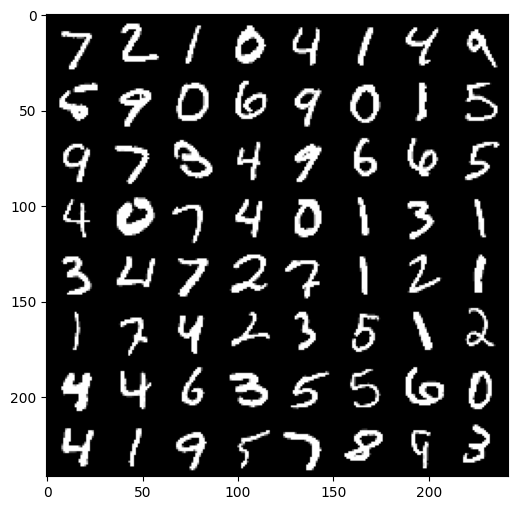

In [84]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show_batch_images(dl):
    for images, labels in dl:
        plt.subplots(figsize = (12, 6))
        plt.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

show_batch_images(predict_dl)

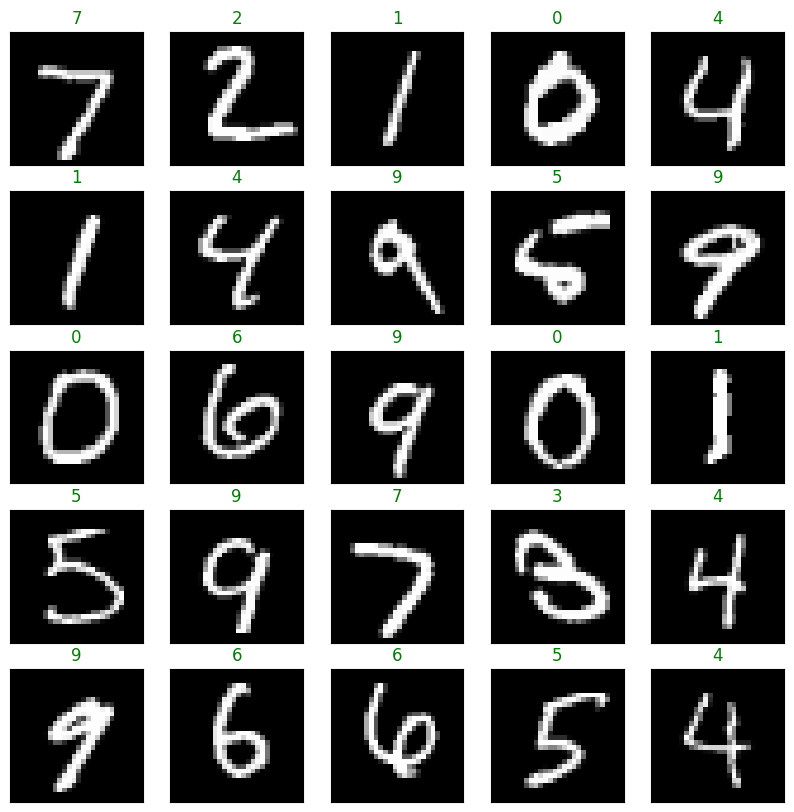

In [85]:
import matplotlib.pyplot as plt

# Get a batch of test data
images, labels = next(iter(predict_dl))

# Get predictions for this batch
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Plot the images and their predicted labels
fig = plt.figure(figsize=(10, 10))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.set_title(str(predicted[i].item()), color=("green" if predicted[i]==labels[i] else "red"))
plt.show()

In [87]:
images[1].shape

torch.Size([1, 28, 28])

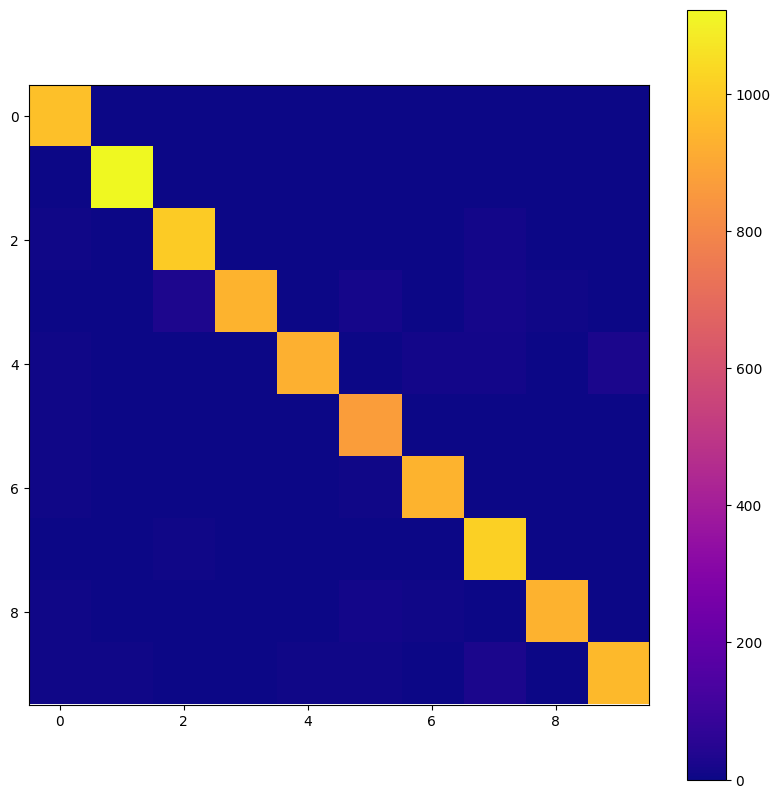

In [90]:
from torchmetrics import ConfusionMatrix

# Initialize the confusion matrix
confmat = ConfusionMatrix(num_classes=10, task='multiclass')

# Update the confusion matrix with the model's predictions
for images, labels in predict_dl:
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    confmat.update(predicted, labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(confmat.compute(), cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()

In [92]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 31835), started 0:00:17 ago. (Use '!kill 31835' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

import pytorch_lightning as pl

In [ ]:
class Net(pl.LightningModule):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        return [optimizer], [scheduler]

In [ ]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )

    def prepare_data(self):
        CIFAR10(root="./data", train=True, download=True)
        CIFAR10(root="./data", train=False, download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = CIFAR10(root="./data", train=True, transform=self.transform)

            # Split the train dataset into train and validation
            self.train_dataset, self.val_dataset = torch.utils.data.random_split(
                self.train_dataset, [45000, 5000]
            )

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=2, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=2)

In [ ]:
model = Net()
data_module = CIFAR10DataModule(batch_size=64)

trainer = pl.Trainer(devices=1, max_epochs=100)
trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


100%|██████████| 170498071/170498071 [00:01<00:00, 106938084.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | conv1 | Conv2d    | 456   
1 | pool  | MaxPool2d | 0     
2 | conv2 | Conv2d    | 2.4 K 
3 | fc1   | Linear    | 48.1 K
4 | fc2   | Linear    | 10.2 K
5 | fc3   | Linear    | 850   
------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# Evaluate on the validation set
trainer.validate(model, data_module.val_dataloader())

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

[{}]